In [1]:
!git clone https://github.com/Kiyong314/Cancel_Detect_Tensorflow_Project.git
!cp -r Cancel_Detect_Tensorflow_Project/lung_preprocessing_results .
!rm -rf Cancel_Detect_Tensorflow_Project

Cloning into 'Cancel_Detect_Tensorflow_Project'...
remote: Enumerating objects: 2143, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 2143 (delta 6), reused 0 (delta 0), pack-reused 2116 (from 2)
Receiving objects: 100% (2143/2143), 338.32 MiB | 40.30 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (2189/2189), done.


In [3]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 22.1 MB/s eta 0:00:00


In [5]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 724.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.8 MB/s eta 0:00:00


In [1]:
# -----------------------------------------------
# 🔧 FocusNet-LC 전체 파이프라인 (Step 1~9 통합 정리)
# -----------------------------------------------

# Step 1️⃣: 라이브러리 불러오기
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D


# Step 2️⃣: 기본 설정 (수동 zip 업로드 방식)
from google.colab import files


# 경로 설정
base_path = "/content/lung_preprocessing_results"
print("압축 풀린 경로 내부 폴더들:", os.listdir(base_path))

# 클래스별 이미지 개수 확인
for folder_name in ["Normal cases", "Bengin cases", "Malignant cases"]:
    full_path = os.path.join(base_path, folder_name)
    full_path = os.path.join(full_path, "processed_images")
    print(f"📂 {folder_name}: {full_path}")
    image_files = glob(os.path.join(full_path, "*.png"))
    print(f"📸 {folder_name}: {len(image_files)} images")

압축 풀린 경로 내부 폴더들: ['Bengin cases', 'processing_statistics.txt', 'Malignant cases', 'Normal cases']
📂 Normal cases: /content/lung_preprocessing_results/Normal cases/processed_images
📸 Normal cases: 413 images
📂 Bengin cases: /content/lung_preprocessing_results/Bengin cases/processed_images
📸 Bengin cases: 120 images
📂 Malignant cases: /content/lung_preprocessing_results/Malignant cases/processed_images
📸 Malignant cases: 560 images


In [33]:
# 이미지 크기 설정
IMG_SIZE = 512

# Step 3️⃣: 폐 ROI 마스크 생성 함수 (논문 Figure 5 기반)
# 이 함수는 CT 이미지에서 폐 부위만 남기기 위한 마스크를 생성합니다.
# Threshold는 0.3 이상인 픽셀을 폐 조직으로 간주하여 선택합니다.
# 이 값은 CT 영상에서 폐가 주변보다 상대적으로 밝은 회색 계열에 위치하므로 설정됩니다.
# 이후 연결 성분 분석을 통해 작은 노이즈(blobs)를 제거합니다.
# Morphological Closing 연산을 두 번 사용해 폐 내부의 작은 구멍들을 메우고 폐 형태를 부드럽게 만듭니다.


# Step 4️⃣: 전처리1 - 이미지 증강 (좌우/상하 반전 등)
# 논문에서는 좌우반전, 상하반전과 같은 augmentation을 통해 일반화 성능을 높였다고 설명
train_datagen = ImageDataGenerator(
    horizontal_flip=True,  # 좌우반전
    vertical_flip=True,    # 상하반전
    rotation_range=10,     # 회전 증강
    zoom_range=0.1         # 확대/축소
)

# Step 5️⃣: 전처리2 - 폐 영역만 남기기 (Remove blobs → ROI 추출 → Fill holes)
def segment_lung_mask_refined(img):
    _, binary = cv2.threshold(img, 0.4, 1.0, cv2.THRESH_BINARY_INV)  # threshold ↑
    binary = binary.astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    sizes = stats[1:, -1]
    min_size = 1000  # 더 작은 블롭 제거
    clean_mask = np.zeros_like(binary)
    for i, size in enumerate(sizes):
        if size >= min_size:
            clean_mask[labels == i + 1] = 1
    closed = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, np.ones((11, 11), np.uint8))  # 커널 키움
    filled = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    return filled


# Step 6️⃣: 전처리3 - 최종 전처리 적용 함수 (흑백화 + 정규화 + 마스크 적용)
# 두 가지 마스크 방식 비교를 위한 분기 처리 추가
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # CT는 흑백이므로 1채널로 읽기
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # 논문 기준 크기 맞추기
    img = img / 255.0  # intensity scaling (논문 Block 1)

    # 선택한 방식에 따라 다른 마스크 생성 함수 적용
    #//mask = segment_lung_mask_refined(img)

    return img #* mask  # 마스크 적용하여 폐 영역만 남김

# Step 5️⃣: 데이터 로딩 함수 (이미지 + 라벨 + 메타데이터)
def load_data_with_preprocessing(preprocess_fn):
    label_dict = {'Normal cases': 0, 'Bengin cases': 1, 'Malignant cases': 2}
    images, labels, meta = [], [], []
    for label_name, label_val in label_dict.items():
        folder_path = os.path.join(base_path, label_name)
        folder_path = os.path.join(folder_path, "processed_images")
        image_paths = glob(os.path.join(folder_path, '*.png'))
        for path in image_paths:
            img = preprocess_fn(path)
            if img is None:
                continue
            images.append(img)
            labels.append(label_val)
            age = 0.1 #np.random.randint(50, 81) / 100
            gender = 0.1 # np.random.randint(0, 2)
            meta.append([age, gender])
    X = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y = to_categorical(labels, num_classes=3)
    meta = np.array(meta)
    return X, y, meta

# Step 6️⃣: 모델 정의 함수 (FocusNet-LC)
def build_focusnetlc(input_shape=(IMG_SIZE, IMG_SIZE, 1), meta_dim=2):
    img_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)

    meta_input = Input(shape=(meta_dim,))
    #combined = concatenate([x, meta_input])
    #x = Dense(256, activation='relu')(combined)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[img_input, meta_input], outputs=output)
    model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 7️⃣: Grad-CAM 히트맵 생성 함수
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    preds = model.predict(img_array)
    pred_index = tf.argmax(preds[0])
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Step 8️⃣: Grad-CAM 시각화 함수
def show_gradcam(img, heatmap, alpha=0.5):
    img = img[0].squeeze()
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3]
    superimposed_img = heatmap_colored * alpha + np.stack([img]*3, axis=-1)
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()

In [34]:
# Step 9️⃣: 전체 실행 (전처리 → 학습 → 평가 → Grad-CAM)
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 로드 및 분할
X, y, meta = load_data_with_preprocessing(preprocess_image)
X_train, X_temp, y_train, y_temp, meta_train, meta_temp = train_test_split(X, y, meta, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test, meta_val, meta_test = train_test_split(X_temp, y_temp, meta_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 모델 생성
model = build_focusnetlc()

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # 검증 정확도 모니터링
    patience=7,                    # 7 에포크 동안 개선 없으면 중단
    restore_best_weights=True,     # 최고 성능 모델로 복원
    verbose=1                      # 중단 메시지 출력
)

# 모델 학습 (EarlyStopping 추가)
print("🚀 Starting training with EarlyStopping...")
history = model.fit(
    [X_train, meta_train], y_train,
    validation_data=([X_val, meta_val], y_val),
    epochs=30,
    batch_size=16,
    callbacks=[early_stopping],    # 📌 EarlyStopping 추가
    verbose=1
)

print(f"\n✅ Training completed!")
print(f"📈 Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"🛑 Training stopped at epoch: {len(history.history['loss'])}")

🚀 Starting training with EarlyStopping...
Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 0.5458 - loss: 0.9944 - val_accuracy: 0.6341 - val_loss: 0.7674
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.6673 - loss: 0.8184 - val_accuracy: 0.7683 - val_loss: 0.6582
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7531 - loss: 0.6173 - val_accuracy: 0.8232 - val_loss: 0.5081
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8204 - loss: 0.4793 - val_accuracy: 0.8415 - val_loss: 0.3950
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8600 - loss: 0.3634 - val_accuracy: 0.8902 - val_loss: 0.3219
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8660 - loss: 0.3057 - val_accuracy: 0.8841 - val_loss: 0.3358
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9090 - loss: 0.2317 - val_accuracy: 0.9329 - val_loss: 0.2727
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.93


✅ Test Accuracy: 98.17 %
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        62
           1       1.00      0.94      0.97        18
           2       0.99      0.99      0.99        84

    accuracy                           0.98       164
   macro avg       0.99      0.97      0.98       164
weighted avg       0.98      0.98      0.98       164


📊 Confusion Matrix:
[[61  0  1]
 [ 1 17  0]
 [ 1  0 83]]


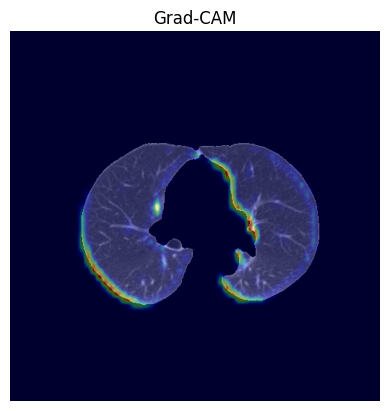

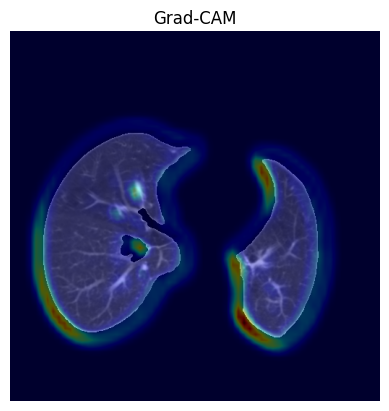

In [48]:
loss, acc = model.evaluate([X_test, meta_test], y_test, verbose=0)
print("\n✅ Test Accuracy:", round(acc * 100, 2), "%")

y_pred_probs = model.predict([X_test, meta_test])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred))
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

last_conv_layer = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
heatmap = make_gradcam_heatmap([X_test[0:1], meta_test[0:1]], model, last_conv_layer)
show_gradcam(X_test[0:1], heatmap)

heatmap = make_gradcam_heatmap([X_test[10:11], meta_test[10:11]], model, last_conv_layer)
show_gradcam(X_test[10:11], heatmap)

In [42]:
import os
import tensorflow as tf
from datetime import datetime

def save_model_as_h5(model, base_dir="/content/"):
    """H5 형식으로 모델 저장"""
    try:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        h5_path = os.path.join(base_dir, f"focusnetlc_model_{timestamp}.h5")

        model.save(h5_path, save_format='h5')
        print(f"✅ H5 형식으로 저장 완료: {h5_path}")
        return h5_path

    except Exception as e:
        print(f"❌ H5 저장 실패: {str(e)}")



def load_h5_model(h5_path):
    """H5 모델 로드"""
    try:
        model = tf.keras.models.load_model(h5_path)
        print(f"✅ H5 모델 로드 완료: {h5_path}")
        return model
    except Exception as e:
        print(f"❌ H5 모델 로드 실패: {str(e)}")
        return None

In [44]:
save_model_as_h5(model)

✅ H5 형식으로 저장 완료: /content/focusnetlc_model_20250608_050226.h5


'/content/focusnetlc_model_20250608_050226.h5'